# Analysis to Propogate Direct Water Use/Well Estimates to Direct Water Use by County and Year

Theodore Barnhart | tbarnhart@usgs.gov | 20170728

In [1]:
import seaborn as sns

In [2]:
IHS = pd.read_csv('./data/IHS_Well_Treatment_2000_2015.csv') # IHS data by county
FF = pd.read_csv('./data/FF_Well_Fluid_2009_2015.csv') # FF data by county
dwu = pd.read_csv('./data/bakken_annual_data.csv') # annual direct water use data
counties = pd.read_excel('./data/BakkenNonCounties.xlsx') # load the county groups (Bakken vs Non-Bakken)

## Melt the data frames

In [5]:
cols = ['county','value','database','year','variable']

In [6]:
def set_group(county):
    for c,group in zip(counties.County,counties.Group):
        if county == c:
            return group

In [7]:
def get_year(var): return int(var[-4:])
def get_tag(var): return var[:-4]

In [8]:
def meltDF(df,db,id,cols):
    tmp = pd.melt(df,id_vars=[id])
    tmp['database'] = db
    tmp['year'] = tmp.variable.map(get_year)
    tmp['tag'] = tmp.variable.map(get_tag)
    del tmp['variable']
    tmp.columns = cols
    tmp['group'] = tmp.county.map(set_group)
    return tmp

In [9]:
dat = pd.concat([meltDF(IHS,'IHS','County',cols),meltDF(FF,'FF','County',cols)])

## Initial Graphs

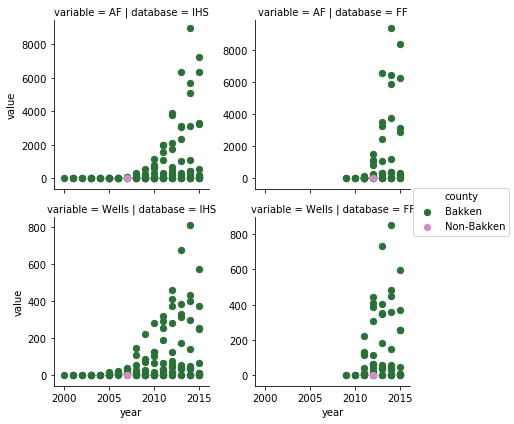

In [10]:
g = sns.FacetGrid(dat,col='database',row='variable',sharey=False, hue = 'group', palette='cubehelix')
g = g.map(plt.scatter,'year','value',s=40)
g.add_legend(title='county')

In [14]:
dat.loc[dat.group=='Non-Bakken'].county.unique()

array(['Burleigh', 'Emmons', 'Pierce'], dtype=object)